In [1]:
import sys
sys.path.append('src')
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from utils import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
PEAK_RATE, KERNEL_WIDTH = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 60 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


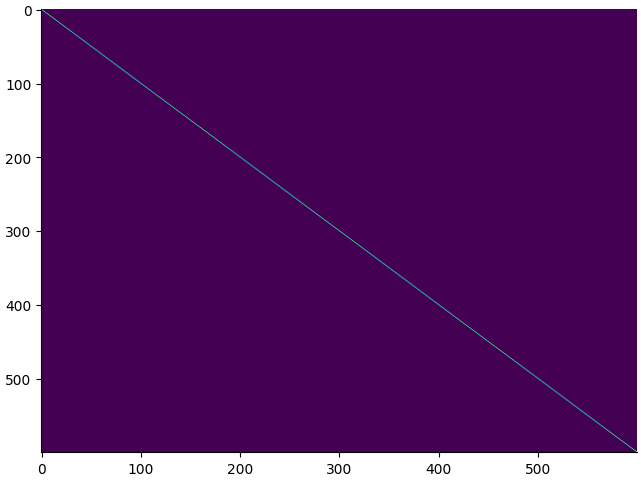

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 1
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)

/tmp/ipykernel_71795/1771619413.py:4: RuntimeWarning: divide by zero encountered in power
  plt.plot(_, np.power(_, -0.5))


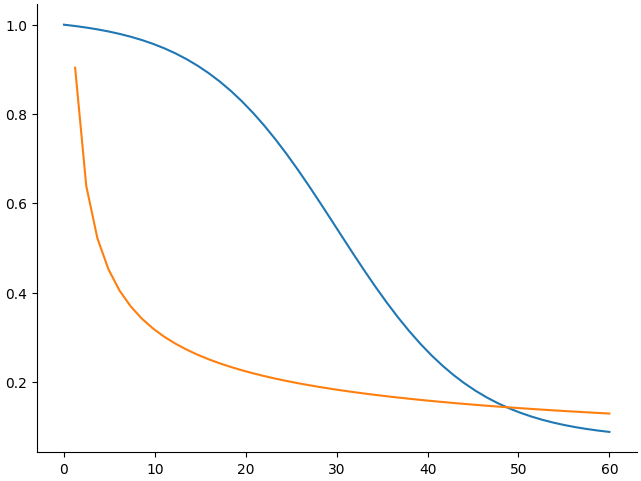

In [6]:
_ = np.linspace(0, N_rend)
y = (np.tanh(-(_-30)/15)+1.15)/2
plt.plot(_, y / y.max())
plt.plot(_, np.power(_, -0.5))

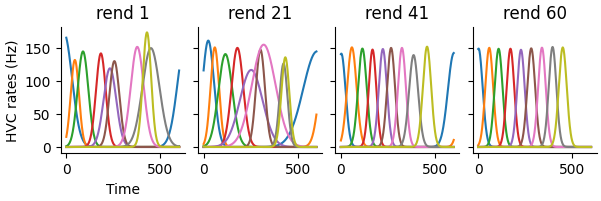

In [7]:
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)
peak_rate = np.zeros_like(burst_ts)
kernel_width = np.zeros_like(burst_ts) + KERNEL_WIDTH
for i in range(N_rend):
    j = (np.tanh(-(i-N_rend/2)/15)+1.15)/2 / (np.tanh(N_rend/2/15)+1.15)/2
    burst_ts[:,i] += rng.normal(loc=0, scale=100*j, size=9)
    peak_rate[:,i] = lognormal_gen(rng, PEAK_RATE, 70*j, size=9)
    kernel_width[:,i] += rng.exponential(60*j, size=9)
rH = generate_HVC(T, burst_ts, peak_rate, kernel_width)

js = (0, int(np.floor(N_rend/3)), int(np.floor(N_rend*2/3)), N_rend-1)
fig, ax = plt.subplots(1, len(js), figsize=(6, 2), sharex='all', sharey='all')
for i, j in enumerate(js):
    ax[i].plot(rH[T_burn+j*T_rend:T_burn+(j+1)*T_rend])
    ax[i].set_title(f'rend {j+1}', fontsize=12)
ax[0].set(xlabel='Time', ylabel='HVC rates (Hz)')
fig.savefig('svg/supplementary/HVC_development.svg')

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [9]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.2, 1.8]) / 4
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [10]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, -4, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [11]:
r_rest = 2 # target rate when phi(0)
rmax, s = 50, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [12]:
w0_mean_HVC2E, w0_std_HVC2E = 1/N_HVC, 1e-3
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05
w_inh_HVC2E = w0_mean_HVC2E
w_inh_E2E = w0_mean_E2E*cW_E2E
tauE, tauI, dt = 30, 10, 1

In [13]:
netFF = WCNet(NE, N_HVC, w0_mean_HVC2E, phi, tauE, 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEI = EINet(NE, NI, N_HVC, w0_mean_HVC2E, phiE, phiI, tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEIrec = EINet(NE, NI, N_HVC, w0_mean_E2E, phiE, phiI, tauE, tauI, 
                 JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                 w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)

Not a recurrent model and rI will not be calculated.


In [14]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-2e-2,
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netFF.sim(hE0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
WsFF = _[2]
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-4e-2), 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netEI.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
WsEI = _[2]
plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-4e-2), 
                         tauW=1e5, J0_mean=J0_mean, asyn_E=10, rE_th=1)
_ = netEIrec.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
WsEIrec = _[2]

100%|███████████████████████████████████| 36499/36499 [00:34<00:00, 1053.50it/s]


Text(0, 0.5, 'Exc. index')

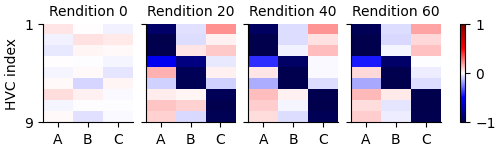

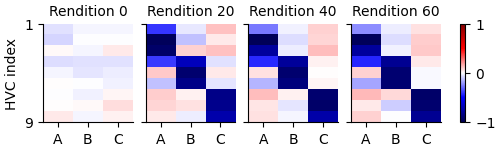

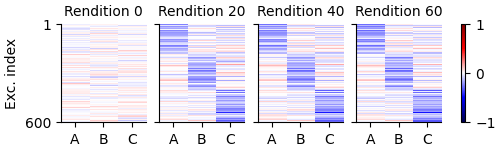

In [15]:
fig, ax = plot_wcol_corr(WsFF, syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('HVC index')
fig, ax = plot_wcol_corr(WsEI['HVC'], syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('HVC index')
fig, ax = plot_wcol_corr(WsEIrec['JEE'], syl, (1, 4), (5, 1.5), sort=True)
ax[0].set_ylabel('Exc. index')

## Test Model with Different Scenarios

In [16]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [17]:
N_repeat = 10
peak_rate = np.zeros((N_HVC, N_repeat))
kernel_width = np.zeros_like(peak_rate) + KERNEL_WIDTH
for i in range(N_repeat):
    j = (np.tanh(-(N_rend-10)/15)+1.25)/2
    burst_ts[:,i] += rng.normal(loc=0, scale=80*j, size=9)
    peak_rate[:,i] = lognormal_gen(rng, PEAK_RATE, 50*j, size=9)
    kernel_width[:,i] += rng.exponential(40*j, size=9)
rH_exp = generate_HVC(T_burn+T_rend*N_repeat, burst_ts, peak_rate, kernel_width)

In [18]:
expFF = Experiment(netFF, rH_exp, syl, noise=1, T_test=T_burn+T_rend*N_repeat, 
                   t_start=tsyl_start[:,:N_repeat], t_end=tsyl_end[:,:N_repeat])
expEI = Experiment(netEI, rH_exp, syl, noise=1, T_test=T_burn+T_rend*N_repeat, 
                   t_start=tsyl_start[:,:N_repeat], t_end=tsyl_end[:,:N_repeat])
expEIrec = Experiment(netEIrec, rH_exp, syl, noise=1, T_test=T_burn+T_rend*N_repeat, 
                   t_start=tsyl_start[:,:N_repeat], t_end=tsyl_end[:,:N_repeat])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert = rng.multivariate_normal(pert_mean, pert_cov, size=syl.shape[0])
pert[[0,2]] = syl[[0,2]].copy()
pert_args = [(pert, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
FF_tests_all = expFF.sim_multi(test_codes, if_sing, pert_args * len(test_codes))
EI_tests_all = expEI.sim_multi(test_codes, if_sing, pert_args * len(test_codes))
EIrec_tests_all = expEIrec.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


In [19]:
def parse_trial(r):
    ret = np.zeros((N_repeat, T_rend+100, r.shape[-1]))
    for i in range(N_repeat):
        ret[i] = r[T_burn+i*T_rend-100:T_burn+(i+1)*T_rend]
    return ret

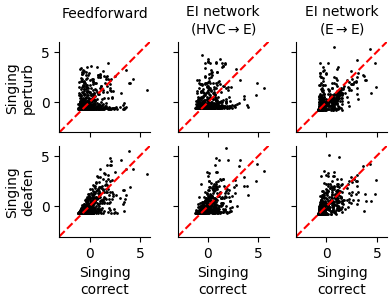

In [20]:
# ti, tj = int(tsyl_start[0,0])-T_burn, int(tsyl_end[2,0])-T_burn+200
ti, tj = int(tsyl_start[1,0])-T_burn, int(tsyl_end[1,0])-T_burn+200
fig, ax = plt.subplots(2, 3, sharex='all', sharey='all', figsize=(4, 3))
for i, res in enumerate((FF_tests_all['rE'][:-1], EI_tests_all['rE'][:-1], 
                         EIrec_tests_all['rE'][:-1])):
    z_ctrl = normalize(parse_trial(res[0])[:,ti:tj].mean(axis=(0,1)), axis=0)
    for j, k in enumerate(('pert', 'deaf')):
        z_pert = normalize(parse_trial(res[j+1])[:,ti:tj].mean(axis=(0,1)), axis=0)
        ax[j,i].plot(z_ctrl, z_pert, 'o', ms=1, c='k')
        ax[j,i].plot([-3,6], [-3,6], c='r', ls='--')
        ax[j,i].set(aspect=1, xlim=[-3,6], ylim=[-3,6])
        ax[-1,i].set(xlabel='Singing\ncorrect')
ax[0,0].set_ylabel('Singing\nperturb')
ax[1,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[0,2].set_title('EI network\n(E$\\to$E)', fontsize=10)
fig.savefig('svg/supplementary/learn_toy_joint_dist_immature_HVC.svg')

/home/zg93/Projects/Aiv-Network/src/utils.py:72: RuntimeWarning: invalid value encountered in divide
  sig2 = sig2.copy() / np.sqrt((sig2**2).sum(axis=-1, keepdims=True))


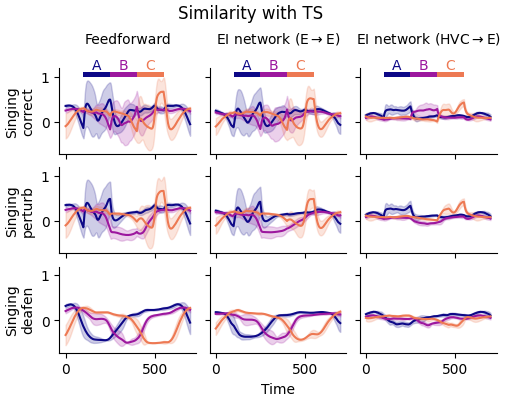

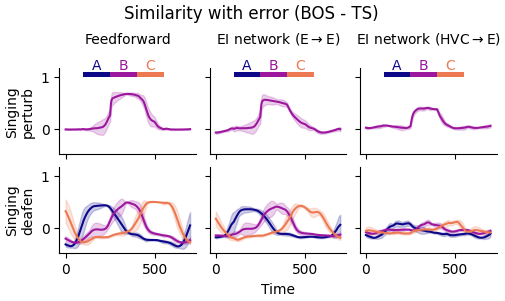

In [21]:
cmap = plt.get_cmap('plasma')

fig1, ax1 = plt.subplots(3, 3, sharex='all', sharey='all', figsize=(5,4))
fig2, ax2 = plt.subplots(2, 3, sharex='all', sharey='all', figsize=(5,3))

fig1.suptitle('Similarity with TS')
fig2.suptitle('Similarity with error (BOS - TS)')

for i, tests_all in enumerate((FF_tests_all, EI_tests_all, EIrec_tests_all)):
    for j, l in enumerate(test_names[:-1]):
        for k in range(3): # 3 syllables
            aux = parse_trial(tests_all['rE'][j])
            _ = correlation(aux, syl, dim=2, cosine=True)
            plot_mean_std(ax1[j,i], _.mean(axis=0)[:,k], _.std(axis=0)[:,k], 
                          a_fill=0.2, c=cmap(k/3))
            if j > 0:
                _ = correlation(aux, tests_all['bos'][j]-syl, dim=2, cosine=True)
                plot_mean_std(ax2[j-1,i], _.mean(axis=0)[:,k], _.std(axis=0)[:,k], 
                              a_fill=0.2, c=cmap(k/3))
                ax2[j-1,0].set_ylabel(l)
        ax1[j,0].set_ylabel(l)
    _  = '(HVC$\\to$E)\n' if i == 2 else '(E$\\to$E)\n'
    ax1[0,i].set_title('Feedforward\n' if i == 0 else 'EI network ' + _)
    ax2[0,i].set_title('Feedforward\n' if i == 0 else 'EI network ' + _)
    
#### Plot syl indicators ####
ts = [(tsyl_start[i,0]-T_burn+100, tsyl_end[i,0]-T_burn+100) for i in range(N_syl)]
for k in range(3):
    y0, y1 = 1, 0.1
    for i, (t0, t1) in enumerate(ts):
        ax1[0,k].add_patch(plt.Rectangle((t0, y0), t1-t0, y1, fc=cmap(i/N_syl), 
                                         clip_on=False, linewidth=0))
        ax1[0,k].text((t1+t0)/2, y0+y1, chr(65+i), color=cmap(i/N_syl), 
                      ha='center', va='bottom')
        
        ax2[0,k].add_patch(plt.Rectangle((t0, y0), t1-t0, y1, fc=cmap(i/N_syl), 
                                         clip_on=False, linewidth=0))
        ax2[0,k].text((t1+t0)/2, y0+y1, chr(65+i), color=cmap(i/N_syl), 
                      ha='center', va='bottom')

ax1[-1,1].set_xlabel('Time')
ax2[-1,1].set_xlabel('Time')

fig1.savefig('svg/supplementary/similarity_TS_immature_HVC.svg')
# fig2.savefig('svg/supplementary/similarity_err_immature_HVC.svg')